## Cartpole using pixels

In [2]:
!pip install pyvirtualdisplay 

In [3]:
!pip3 install box2d-py

In [4]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:14 http://ppa.launchpad.net/graph

In [5]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [6]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [7]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [8]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

### Experience replay (Replay Memory)

In [9]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

### Policy network

#### Network definition

In [10]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)
    
    

In [11]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

In [12]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

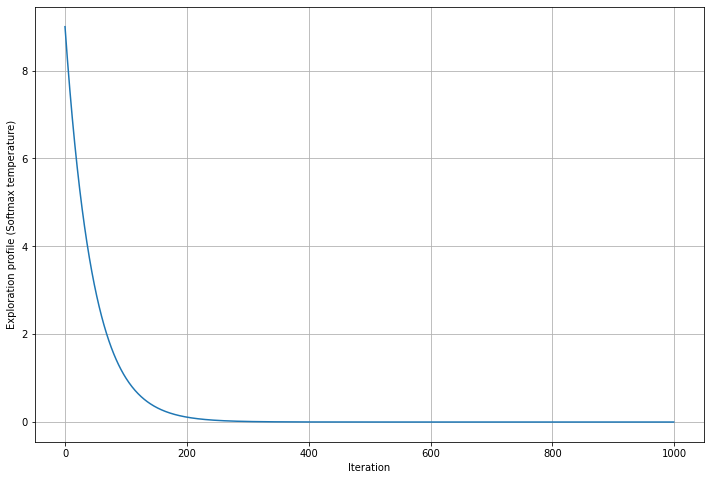

In [13]:
### Define exploration profile
initial_value = 9
#num_iterations = 1000
num_iterations = 1000

exp_decay = np.exp(-np.log(initial_value) / num_iterations * 10) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [14]:
### Create environment
env = gym.make('LunarLander-v2') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 8
ACTION SPACE SIZE: 4


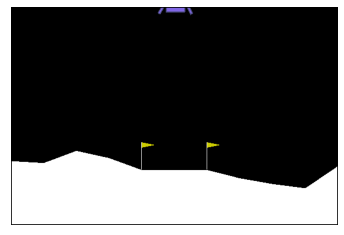

In [15]:
def get_screen(env):
    ''' Extract one step of the simulation.'''
    # Get RGB
    # Images are 600x400 pixels
    screen = env.render(mode='rgb_array')#.transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return screen

env = gym.make('LunarLander-v2') 
state = env.reset()
screen = get_screen(env)
env.close()
plt.imshow(screen)
plt.yticks([])
plt.xticks([])
plt.show()

## random agent

In [15]:
# Initialize the Gym environment

env.seed(0) # Set a random seed for the environment (reproducible results)
# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)


final_score = []
# Let's try for a total of 10 episodes
for num_episode in range(100): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
    
    # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    final_score.append(score)
    
env.close()


EPISODE 1 - FINAL SCORE: -484.3578511233964
EPISODE 2 - FINAL SCORE: -301.88394215353026
EPISODE 3 - FINAL SCORE: -342.5659323380559
EPISODE 4 - FINAL SCORE: -396.8385940115734
EPISODE 5 - FINAL SCORE: -236.08619277078873
EPISODE 6 - FINAL SCORE: -333.51903048175825
EPISODE 7 - FINAL SCORE: -270.29251608480934
EPISODE 8 - FINAL SCORE: -678.7297291216588
EPISODE 9 - FINAL SCORE: -435.4192516972587
EPISODE 10 - FINAL SCORE: -192.99982748025747
EPISODE 11 - FINAL SCORE: -357.25515850864866
EPISODE 12 - FINAL SCORE: -198.22853016842384
EPISODE 13 - FINAL SCORE: -382.4081590834638
EPISODE 14 - FINAL SCORE: -436.0873043365919
EPISODE 15 - FINAL SCORE: -412.1906627920956
EPISODE 16 - FINAL SCORE: -541.868417363024
EPISODE 17 - FINAL SCORE: -556.1243978436472
EPISODE 18 - FINAL SCORE: -369.87170727451155
EPISODE 19 - FINAL SCORE: -259.176177701195
EPISODE 20 - FINAL SCORE: -399.9637870933806
EPISODE 21 - FINAL SCORE: -162.10065755271904
EPISODE 22 - FINAL SCORE: -548.2285178003035
EPISODE 23 -

In [16]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.0.1309.video000000.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000001.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000002.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000003.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000004.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000005.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000006.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000007.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000008.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000009.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000010.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000011.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000012.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000013.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000014.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000015.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000016.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000017.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000018.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000019.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000020.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000021.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000022.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000023.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000024.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000025.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000026.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000027.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000028.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000029.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000030.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000031.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000032.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000033.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000034.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000035.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000036.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000037.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000038.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000039.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000040.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000041.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000042.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000043.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000044.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000045.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000046.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000047.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000048.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000049.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000050.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000051.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000052.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000053.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000054.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000055.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000056.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000057.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000058.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000059.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000060.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000061.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000062.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000063.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000064.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000065.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000066.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000067.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000068.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000069.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000070.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000071.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000072.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000073.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000074.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000075.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000076.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000077.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000078.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000079.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000080.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000081.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000082.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000083.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000084.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000085.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000086.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000087.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000088.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000089.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000090.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000091.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000092.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000093.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000094.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000095.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000096.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000097.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000098.mp4



SHOWING VIDEO video/openaigym.video.0.1309.video000099.mp4


In [16]:
import seaborn as sns; sns.set_theme()


Text(0, 0.5, 'Frequency')

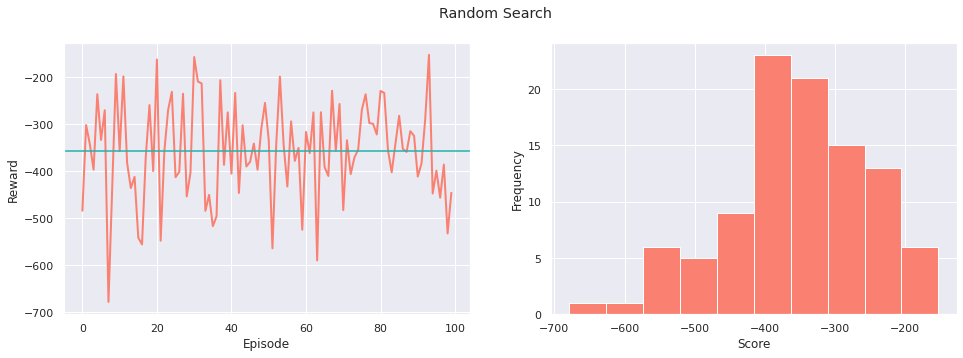

In [18]:
# Define the figure
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
f.suptitle("Random Search")

ax[0].plot(final_score,linewidth = 2 ,  color = 'salmon')
ax[0].axhline(np.mean(final_score),  color = 'lightseagreen')
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Reward')

ax[1].hist(final_score, color = 'salmon')
ax[1].set_xlabel('Score')
ax[1].set_ylabel('Frequency')

## Network update

In [17]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

gamma = 0.98   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [18]:
def initialize(params, replay_memory_capacity=10000, state_space_dim=8, action_space_dim=4):
    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=params['lr']) # The optimizer will update ONLY the parameters of the policy network

    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn


In [19]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states  = np.array( [s[0] for s in batch], dtype=np.float32 )
    states = torch.from_numpy(states)
    actions = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states =  np.array([s[2] for s in batch if s[2] is not None], dtype=np.float32)# the next state can be None if the game has ended
    non_final_next_states = torch.from_numpy(non_final_next_states)
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

### Training

In [20]:
def training_loop(policy_net, target_net, replay_mem, exploration_profile, params, verbose=False):
    # Initialize the Gym environment
    env = gym.make('LunarLander-v2') 
    env.seed(0) # Set a random seed for the environment (reproducible results)
    # This is for creating the output video in Colab, not required outside Colab
    env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

    training_score = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # Apply a small linear bonus if the lander is going down (y-vel <0)
            bonus = -1.5 * state[4] if state[4] <0 else 0
            
            reward = reward + bonus

            # Update the final score (+1 for each step)
            score += reward

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += params['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, params['gamma'], optimizer, loss_fn, params['batch_size'])

            # Visually render the environment (disable to speed up the training)
            if episode_num % 100 == 0:
                env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % params['target_net_update_steps'] == 0:
            if verbose: print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if verbose: print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
        training_score.append(score)
    env.close()
    
    return policy_net, training_score

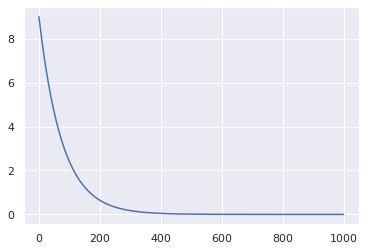

In [28]:
def exp_decay(num_iterations=1000, initial_value=5):
    exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
    exploration_profile = np.array([initial_value * (exp_decay ** i) for i in range(num_iterations)])
    
    return exploration_profile

explorations = []
init_val = [9]
for i in init_val:
    exp = exp_decay(initial_value=i)       
    explorations.append(exp)
    plt.plot(exp)

In [29]:
### PARAMETERS
parameters = {}
parameters['gamma'] = 0.99   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
parameters['lr'] = 0.06   # Optimizer learning rate
parameters['target_net_update_steps'] = 5  # Number of episodes to wait before updating the target network
parameters['batch_size'] = 128  # Number of samples to take from the replay memory for each update
parameters['bad_state_penalty'] = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000

In [30]:
parameters = []
final_score = []
final_profile = []

for i in range(len(explorations)):
    
    ### Set exploration profile
    exploration_profile = explorations[i]
    
    ### PARAMETERS
    params = {}
    params['gamma'] = 0.98   # gamma parameter for the long term reward
    replay_memory_capacity = 10000   # Replay memory capacity
    params['lr'] = 1e-2   # Optimizer learning rate
    params['target_net_update_steps'] = 10   # Number of episodes to wait before updating the target network
    params['batch_size'] = 128  # Number of samples to take from the replay memory for each update
    params['bad_state_penalty'] = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
    
    min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

    ### Initialization
    replay_mem, policy_net, target_net, optimizer, loss_fn = initialize(params)
    
    ### Training
    policy_net, training_score = training_loop(policy_net, target_net, replay_mem, exploration_profile, 
                                                params, verbose=False)
    
    parameters.append(params)
    final_score.append(training_score)
    final_profile.append(exploration_profile)

In [31]:
show_videos()


SHOWING VIDEO video/openaigym.video.1.3143.video000000.mp4



SHOWING VIDEO video/openaigym.video.1.3143.video000100.mp4



SHOWING VIDEO video/openaigym.video.1.3143.video000200.mp4



SHOWING VIDEO video/openaigym.video.1.3143.video000300.mp4



SHOWING VIDEO video/openaigym.video.1.3143.video000400.mp4



SHOWING VIDEO video/openaigym.video.1.3143.video000500.mp4



SHOWING VIDEO video/openaigym.video.1.3143.video000600.mp4



SHOWING VIDEO video/openaigym.video.1.3143.video000700.mp4



SHOWING VIDEO video/openaigym.video.1.3143.video000800.mp4



SHOWING VIDEO video/openaigym.video.1.3143.video000900.mp4


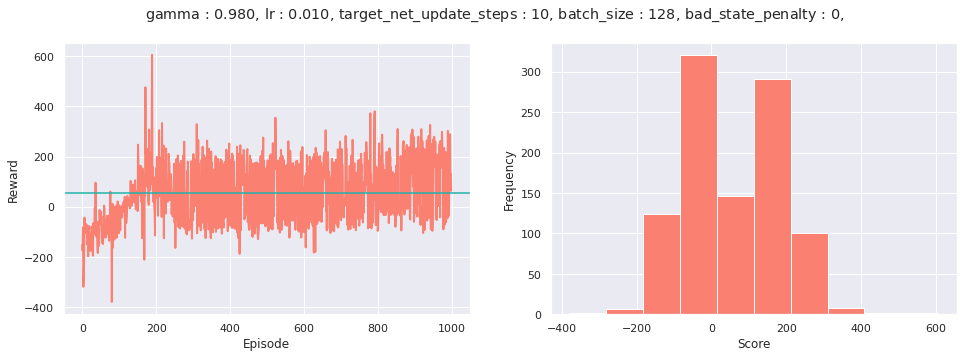

In [32]:
for i in range(len(explorations)): init:3
    plot_results(final_score[i], parameters[i] )

In [24]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.0.3143.video000000.mp4



SHOWING VIDEO video/openaigym.video.0.3143.video000100.mp4



SHOWING VIDEO video/openaigym.video.0.3143.video000200.mp4



SHOWING VIDEO video/openaigym.video.0.3143.video000300.mp4

SHOWING VIDEO video/openaigym.video.0.3143.video000400.mp4



SHOWING VIDEO video/openaigym.video.0.3143.video000500.mp4



SHOWING VIDEO video/openaigym.video.0.3143.video000600.mp4



SHOWING VIDEO video/openaigym.video.0.3143.video000700.mp4



SHOWING VIDEO video/openaigym.video.0.3143.video000800.mp4



SHOWING VIDEO video/openaigym.video.0.3143.video000900.mp4


In [25]:
def plot_results(scores, params):
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    
    text = ''
    for i in params.keys():
        if type(params[i]) == int:
            text += i + (' : $ %i $, ' %(params[i]) )
        else:
            text += i + (' : $ %.3f $, ' %(params[i]) )
    
    f.suptitle(text)
    
    ax[0].plot(scores,linewidth = 2 ,  color = 'salmon')
    ax[0].axhline(np.mean(final_score),  color = 'lightseagreen')
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Reward')
    
    ax[1].hist(scores, color = 'salmon')
    ax[1].set_xlabel('Score')
    ax[1].set_ylabel('Frequency')
  #  ax[1].text(max(scores)-100,100, text, color='black')

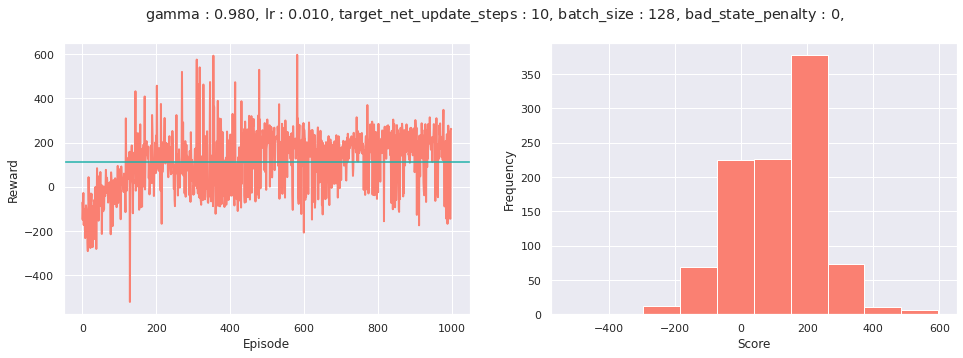

In [26]:
for i in range(len(explorations)):
    plot_results(final_score[i], parameters[i] )

Final test

In [ ]:
### Initialization
replay_mem, policy_net, target_net, optimizer, loss_fn = initialize(parameters[0])

### Training
policy_net, training_score = training_loop(policy_net, target_net, replay_mem, exploration_profile, 
                                            parameters[0], verbose=False)

In [27]:
# Initialize the Gym environment
env = gym.make('LunarLander-v2') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 272.08426216645216
EPISODE 2 - FINAL SCORE: 195.99952985924816
EPISODE 3 - FINAL SCORE: 133.47025913171814
EPISODE 4 - FINAL SCORE: 163.84733982355345
EPISODE 5 - FINAL SCORE: -13.809189689895227
EPISODE 6 - FINAL SCORE: 158.12892158991332
EPISODE 7 - FINAL SCORE: -103.30572744636473
EPISODE 8 - FINAL SCORE: 199.70468536006396
EPISODE 9 - FINAL SCORE: -50.81685865813567
EPISODE 10 - FINAL SCORE: 229.15999532087227
